Notes:
- Image size seem to be constant at 320w 240h

In [ ]:
# !pip install polvo

In [2]:
# !nvidia-smi

In [ ]:
# !pip install "timm>=0.6.2.dev0"

In [1]:
from fastai.vision.all import *

In [8]:
import polvo
from polvo.core import *

In [2]:
# data_dir = Path('drive/MyDrive/cancer_infrared')
# data_dir = Path('/content/drive/My Drive/Projeto Linda Lifetech - Alysson-Lucas/original models')
data_dir = Path.home() / 'data/Projeto Linda Lifetech - Alysson-Lucas/original models'

In [4]:
image_files = get_image_files(data_dir/'set.2313.train_test')
len(image_files)

2320

In [5]:
def get_label(image_file):
    return image_file.parent.name

In [6]:
# convert to grayscale because thermic photos don't make sense on pretrained model
def open_as_grayscale_3channels(image_file):
    image = PILImage.create(image_file, mode="L")
    image = np.array(image)[..., None]
    image = np.repeat(image, 3, axis=-1)
    return PILImage.create(image)

In [7]:
splits = GrandparentSplitter(valid_name='test')(image_files)
len(splits[0]), len(splits[1])

(1856, 464)

In [9]:
x_pipe = [open_as_grayscale_3channels]
y_pipe = [get_label, Categorize()]

dss = Datasets(image_files, [x_pipe, y_pipe], splits=splits)

In [10]:
exp = ClassificationExplorer.from_datasets(dss)

In [11]:
exp.most_common()

,label_id,label,idx,n_samples
0,0,NaoSuspeito,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]",1738
1,1,Suspeito,"[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, ...]",582


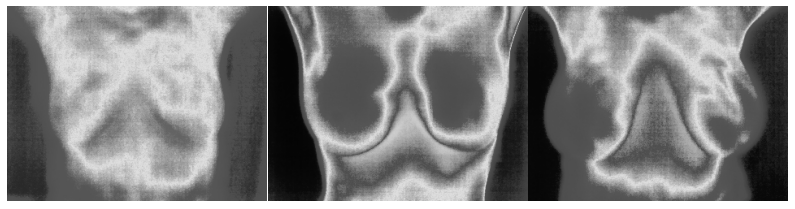

In [18]:
exp.show_label_id(0, slice_=slice(0, 3))

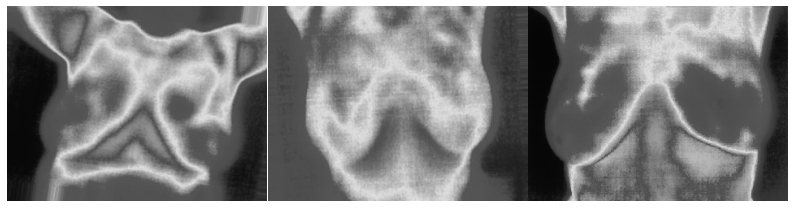

In [19]:
exp.show_label_id(1, slice_=slice(0, 3))

In [20]:
cats = []
for img, cat in progress_bar(dss.train):
    cats.append(cat)
cats = np.array(cats)
Counter(cats)

Counter({0: 1391, 1: 465})

In [25]:
counts = np.array([1391, 465])
1 / np.sqrt(counts)

array([0.02681245, 0.04637389])

In [26]:
# dss.show(dss[0])

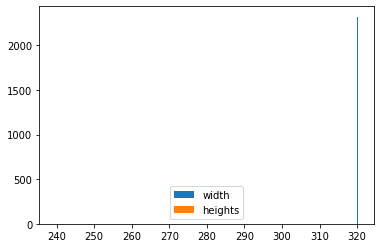

In [27]:
image_sizes_hist(image_files)

In [ ]:
(xs, ys), idxs = one_batch_with_idxs(dl, unique_idx=unique_idx)

In [41]:
320 / 240

1.3333333333333333

In [42]:
320 / 1.33

240.6015037593985

In [43]:
# TODO: start using this function, stil lmore alterations needed
def get_dls(size, presize=(240, 320), min_scale=0.8, max_zoom=1.1, weighted=False):
    # after_item = [ToTensor(), Resize((240, 320))]
    after_item = [ToTensor(), Resize((240, 320), method='squish')]
    after_batch = [IntToFloatTensor(), *aug_transforms(size=size, min_scale=min_scale, max_lighting=0.2, max_zoom=max_zoom)]

    if weighted:
        weights = np.ones(len(cats)) * 0.02676439
        weights[cats] = 0.0463
        return dss.weighted_dataloaders(weights, 32, after_item=after_item, after_batch=after_batch)
    else:
        return dss.dataloaders(32, after_item=after_item, after_batch=after_batch)

In [44]:
dls = get_dls((120, 160))

In [30]:
# have to be careful with cropping, possible to crop an important region
after_item = [ToTensor(), Resize((240, 320))]
after_batch = [IntToFloatTensor(), *aug_transforms(size=(120, 160), min_scale=0.8, max_lighting=0.2, max_zoom=1.1)]
# after_batch = [IntToFloatTensor()]
dls = dss.dataloaders(32, after_item=after_item, after_batch=after_batch)

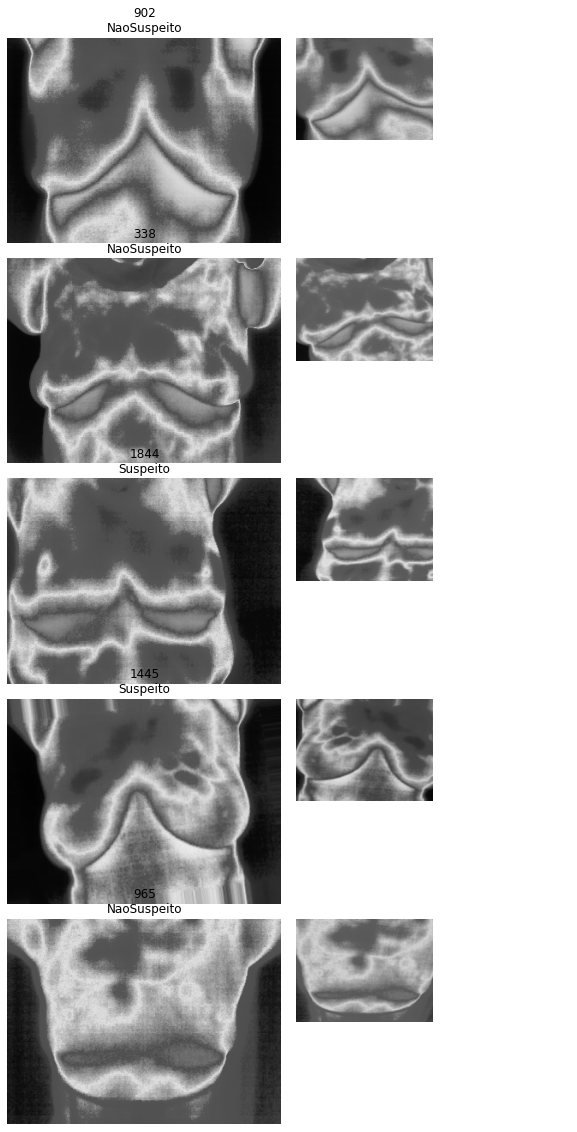

In [45]:
show_tfms(dls.train, unique_idx=None)

In [ ]:
# dls.show_batch(unique=True)

In [35]:
metrics = [error_rate, F1Score(), Recall()]
# arch = 'convnext_tiny_in22k'
arch = resnet34

In [37]:
probs_fn = partial(polvo.classification.baseline.fixed_probs, class_id=0)
polvo.classification.baseline.calculate_metrics(dls.valid, metrics, probs_fn)

{'error_rate': TensorBase(0.2522), 'f1_score': 0.0, 'recall_score': 0.0}

In [36]:
probs_fn = polvo.classification.baseline.random_probs
polvo.classification.baseline.calculate_metrics(dls.valid, metrics, probs_fn)

{'error_rate': TensorBase(0.5000),
 'f1_score': 0.32947976878612717,
 'recall_score': 0.48717948717948717}

In [ ]:
# learn = vision_learner(dls, arch, metrics=metrics).to_fp16()
# learn.fine_tune(3, 0.002)

## Progressive resizing

In [46]:
def get_dls(size, min_scale=0.8, max_zoom=1.1, weighted=False):
    # after_item = [ToTensor(), Resize((240, 320))]
    after_item = [ToTensor(), Resize(320, method='squish')]
    after_batch = [IntToFloatTensor(), *aug_transforms(size=size[1], min_scale=min_scale, max_lighting=0.2, max_zoom=max_zoom)]

    if weighted:
        weights = np.ones(len(cats)) * 0.02676439
        weights[cats] = 0.0463
        return dss.weighted_dataloaders(weights, 32, after_item=after_item, after_batch=after_batch)
    else:
        return dss.dataloaders(32, after_item=after_item, after_batch=after_batch)

In [47]:
def train(epochs, lr, size, cbs=None, **kwargs):
    learn.dls = get_dls(size=size, **kwargs)
    learn.fine_tune(epochs, lr, cbs=cbs)
    learn.save(str(size))

In [48]:
metrics = [error_rate, F1Score(), Recall()]
# loss_func = CrossEntropyLossFlat(weight=tensor([1.0, 10.0]).cuda())
loss_func = None
# arch = 'convnext_tiny_in22k'
arch = resnet34
learn = vision_learner(dls, arch, metrics=metrics, loss_func=loss_func).to_fp16()

/home/lgvaz/miniconda3/envs/fastai/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/home/lgvaz/miniconda3/envs/fastai/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# dls = get_dls(size=(120, 160))
# dls.show_batch()

In [49]:
train(3, 0.002, size=(120, 160))

epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.862927,0.519783,0.140086,0.628571,0.470085,00:23


epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.547332,0.318250,0.103448,0.764706,0.666667,00:08
1,0.413896,0.418864,0.103448,0.741935,0.589744,00:07
2,0.339380,0.354874,0.086207,0.793814,0.658120,00:08


In [50]:
train(4, 0.002, size=(160, 214))

epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.283491,0.400847,0.066810,0.847291,0.735043,00:08


epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.245858,0.271725,0.058190,0.872038,0.786325,00:09
1,0.235373,0.414153,0.105603,0.735135,0.581197,00:09
2,0.197267,0.303157,0.077586,0.820000,0.700855,00:09
3,0.161997,0.305865,0.079741,0.815920,0.700855,00:09


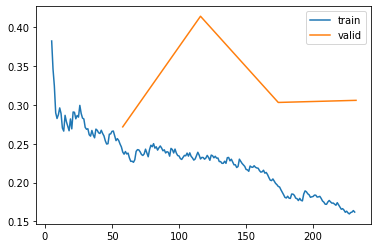

In [51]:
learn.recorder.plot_loss()

In [52]:
learn.export('(160, 214).pkl')

In [ ]:
train(5, 0.002/2, size=(200, 266))

epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.229162,0.408570,0.064655,0.852941,0.743590,00:22


epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.203091,0.387475,0.064655,0.852941,0.743590,00:24
1,0.195100,0.305289,0.064655,0.852941,0.743590,00:23
2,0.184530,0.272079,0.064655,0.852941,0.743590,00:23
3,0.158709,0.268846,0.068966,0.841584,0.726496,00:23
4,0.147899,0.274558,0.068966,0.841584,0.726496,00:22


In [ ]:
train(6, 0.002/3, size=(240, 320))
# train(5, 0.002/1, size=(240, 320), min_scale=1.0, max_zoom=1.0)

epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.209856,0.421633,0.084052,0.800000,0.666667,00:25


epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.183681,0.416183,0.075431,0.824121,0.700855,00:27
1,0.172754,0.391076,0.084052,0.800000,0.666667,00:26
2,0.169141,0.388137,0.081897,0.806122,0.675214,00:26
3,0.156848,0.408850,0.090517,0.781250,0.641026,00:26
4,0.153085,0.378334,0.075431,0.824121,0.700855,00:27
5,0.146301,0.351226,0.075431,0.824121,0.700855,00:27


In [ ]:
train(3, 0.002/3, size=(240, 320), weighted=True)

epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.160339,0.315682,0.071121,0.835821,0.717949,00:24


epoch,train_loss,valid_loss,error_rate,f1_score,recall_score,time
0,0.147180,0.380103,0.073276,0.830000,0.709402,00:26
1,0.128798,0.385309,0.075431,0.824121,0.700855,00:26
2,0.112779,0.398468,0.079741,0.812183,0.683761,00:27


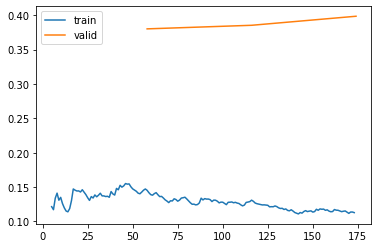

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.load('(240, 320)')

In [ ]:
learn.metrics += [RocAucBinary()]

In [ ]:
learn.validate()

(#5) [0.3984683156013489,0.07974138110876083,0.8121827411167513,0.6837606837606838,0.9620187689351954]

<function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

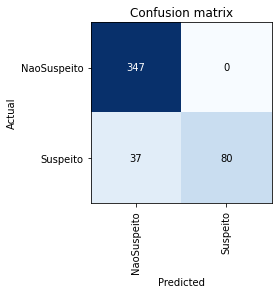

In [ ]:
interp.plot_confusion_matrix()

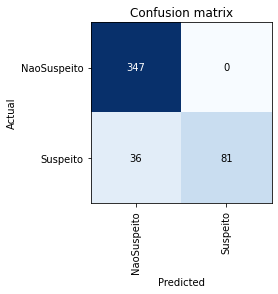

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
preds,targs = learn.get_preds()

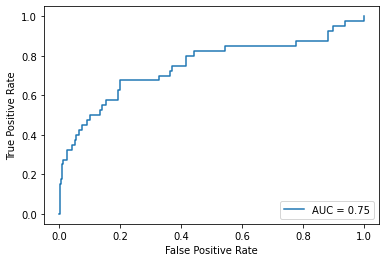

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

fpr, tpr, thresholds = roc_curve(targs, preds[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [ ]:
# optimal threshold
thresh = thresholds[np.argmax(tpr-fpr)]
thresh

0.018475594

In [ ]:
preds2 = preds[:,1] > thresh

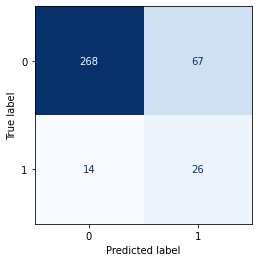

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(targs, preds2, cmap="Blues", colorbar=False)

In [ ]:
(tpr[60], fpr[60])

(0.9, 0.5671641791044776)

In [ ]:
(tpr[52], fpr[52])

(0.825, 0.42388059701492536)